# ASD Classifier

In [92]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ggplot import *
%matplotlib inline 
plt.style.use('fivethirtyeight')
# sns.set_style('whitegrid')

###  Read data

In [43]:
def read_data(filename = 'Autism-Adult-Data.arff'):
    from scipy.io import arff
    filename = filename
    data = arff.loadarff('./data/{}'.format(filename))
    df = pd.DataFrame(data[0])
    print('Finish reading <{}.arff> file'.format(filename))
    return df

In [44]:
children_df = read_data('Autism-Child-Data.arff')
adult_df = read_data('Autism-Adult-Data.arff')
# adult_df.head()

Finish reading <Autism-Child-Data.arff.arff> file
Finish reading <Autism-Adult-Data.arff.arff> file


In [45]:
adult_df.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,...,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,b'1',b'1',b'1',b'1',b'0',b'0',b'1',b'1',b'0',b'0',...,b'f',b'White-European',b'no',b'no',"b""'United States'""",b'no',6.0,"b""'18 and more'""",b'Self',b'NO'
1,b'1',b'1',b'0',b'1',b'0',b'0',b'0',b'1',b'0',b'1',...,b'm',b'Latino',b'no',b'yes',b'Brazil',b'no',5.0,"b""'18 and more'""",b'Self',b'NO'
2,b'1',b'1',b'0',b'1',b'1',b'0',b'1',b'1',b'1',b'1',...,b'm',b'Latino',b'yes',b'yes',b'Spain',b'no',8.0,"b""'18 and more'""",b'Parent',b'YES'
3,b'1',b'1',b'0',b'1',b'0',b'0',b'1',b'1',b'0',b'1',...,b'f',b'White-European',b'no',b'yes',"b""'United States'""",b'no',6.0,"b""'18 and more'""",b'Self',b'NO'
4,b'1',b'0',b'0',b'0',b'0',b'0',b'0',b'1',b'0',b'0',...,b'f',b'?',b'no',b'no',b'Egypt',b'no',2.0,"b""'18 and more'""",b'?',b'NO'


### Clean up the data: change data format 

In [46]:
def clean_df(data_df):
    df = data_df.copy()
    # convert bytes col into string col
    str_df = df.select_dtypes([np.object])
    str_df = str_df.stack().str.decode('utf-8').unstack()
    for col in str_df:
        df[col] = str_df[col]
    # replace missing data(?) as np.nan
    df.replace( {'?': np.nan}, regex=False,inplace=True)
    # convert yes/no to 1/0 
    df.replace( {'yes': 1, 'no': 0}, regex=False,inplace=True)
    df.replace( {'YES': 1, 'NO': 0}, regex=False,inplace=True)
    # convert female/male to 1/0
    df.replace({'gender': {'f': 1, 'm': 0}}, regex=False,inplace=True)
    # change the first 10 cols dtype from string into int 
    df[list(df.columns[0:10])] = df[list(df.columns[0:10])].astype(np.int)
    # clean the ethnicity column 
    df.ethnicity =[x.replace("'",'').strip(' ') if (x == "'Middle Eastern '" or x == "'South Asian'") else x for x in df.ethnicity ]
    
    # clean the country list 
    df.contry_of_res =[x.replace("'",'').strip(' ') 
                       if (x == "'United States'" or 
                           x == "'United Kingdom'" or 
                           x == "'United Arab Emirates'" or
                           x == "'South Africa'" or 
                           x == "'New Zealand'" or 
                           x == "'Saudi Arabia'" or 
                           x == "'South Korea'" or 
                           x == "'Costa Rica'" or
                           x == "'U.S. Outlying Islands'" or 
                           x == "'Isle of Man'" or 
                           x == "'Sri Lanka'" or 
                           x == "'Sierra Leone'" or
                           x == "'Viet Nam'" or 
                           x == "'Hong Kong'" or 
                           x == "'Czech Republic'"
                          ) else x for x in df.contry_of_res ]
    # strip age_desc
    df.age_desc =[x.strip("'") for x in df.age_desc ]
    df.age_desc = [1 if x =='18 and more' else 0 for x in df.age_desc ] 
    # 1 for adult and 0 for children
    
    # strip relation 
    df.relation =[x.replace("'",'').strip(' ') if (x == "'Health care professional'") else x for x in df.relation]
    return df 

In [202]:
adult_c = clean_df(adult_df)
children_c = clean_df(children_df)
combined = adult_c.append(children_c, ignore_index = True)

In [48]:
combined.age_desc.unique()

array([1, 0], dtype=int64)

### Exploratory Data Analysis

In [49]:
# children_c.describe()

In [50]:
# adult_c.describe()

In [140]:
# combined.describe().to_csv('stats.csv')

In [52]:
combined['Class/ASD'].sum()

330

In [12]:
# adult_c['Class/ASD'].sum()

In [13]:
# children_c['Class/ASD'].sum()

## TSNE function 

In [136]:
# def tsne_plot(data_df, title = 'tSNE dimensions for adult dataset'):
#     from sklearn.manifold import TSNE
#     df = data_df
#     tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=300)
#     tsne_results = tsne.fit_transform(df[df.columns[0:10]].values)
#     # plot 
#     df_tsne = df.copy()
#     df_tsne['x-tsne'] = tsne_results[:,0]
#     df_tsne['y-tsne'] = tsne_results[:,1]
#     chart1 = ggplot( df_tsne, aes(x='x-tsne', y='y-tsne', color='Class/ASD') ) \
#             + geom_point(size=75,alpha=0.7) \
#             + ggtitle(title)
#     return chart1

In [134]:
# tsne_plot(adult_c, title = 'tSNE dimensions for ADULT dataset')

In [135]:
# tsne_plot(children_c, title = 'tSNE dimensions for CHILDREN dataset')

## TSNE
- Need to plot two sets hues, class and identity
- fill null with column mean

In [81]:
# combined.age
for i in list(np.where(combined.age.isnull())[0]):
    combined.age.iloc[i] = int(combined.age.mean())
    print(combined.age.iloc[i])

In [82]:
int(combined.age.mean())

22

In [83]:
nums = combined.select_dtypes(include=[np.number])
nums.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,jundice,austim,used_app_before,result,age_desc,Class/ASD
0,1,1,1,1,0,0,1,1,0,0,26.0,1,0,0,0,6.0,1,0
1,1,1,0,1,0,0,0,1,0,1,24.0,0,0,1,0,5.0,1,0
2,1,1,0,1,1,0,1,1,1,1,27.0,0,1,1,0,8.0,1,1
3,1,1,0,1,0,0,1,1,0,1,35.0,1,0,1,0,6.0,1,0
4,1,0,0,0,0,0,0,1,0,0,40.0,1,0,0,0,2.0,1,0


In [84]:
plot = nums.values[:,0:-1]
plot.shape

(996, 17)

In [86]:
# nan values in age column
list(np.where(nums.isnull())[0])
# now there is no nan in nums

[]

### COMBINED DATA
- here with both adult and children data 

In [87]:
# Visualize in 2D using TSNE
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(plot)

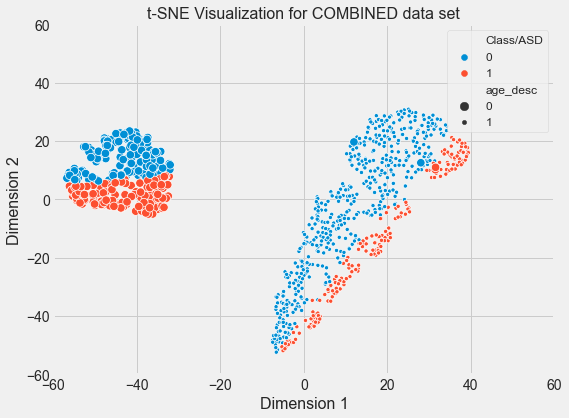

In [119]:
plot = nums.values[:,0:-1]
plot.shape
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(plot)
# Plot
plt.figure(figsize=(8, 6))
ax = plt.subplot(111)
# cmap = sns.color_palette(n_colors=2)

sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1],
                     hue= 'Class/ASD',
#                      sizes=(100, 200),
                alpha = 1,
               data = nums,
               size = 'age_desc')

plt.axis((-60, 60, -60, 60))
plt.title('t-SNE Visualization for COMBINED data set', fontsize=16)
plt.xlabel('Dimension 1', fontsize=16)
plt.ylabel('Dimension 2', fontsize=16)
plt.legend(loc="best", fontsize=12)

# x_ticks = np.array([-60, -40, -20, 0, 20, 40, 60])
# ax.set_xticklabels(x_ticks, rotation=0, fontsize=16)
# y_ticks = np.array([-60, -40, -20, 0, 20, 40, 60])
# ax.set_yticklabels(y_ticks, rotation=0, fontsize=16)

In [107]:
# tsne_plot(combined, title = 'tSNE dimensions for COMBINED dataset')

In [111]:
# nums[nums['age_desc'] ==1] ## choose adults

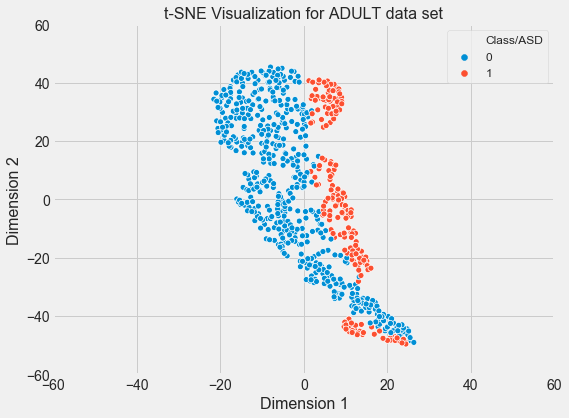

In [120]:
plot = nums[nums['age_desc'] ==1].values[:,0:-1]
plot.shape
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(plot)
# Plot
plt.figure(figsize=(8, 6))
ax = plt.subplot(111)
# cmap = sns.color_palette(n_colors=2)

sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1],
                     hue= 'Class/ASD',
#                      sizes=(100, 200),
                alpha = 1,
               data = nums[nums['age_desc'] ==1],
               )

plt.axis((-60, 60, -60, 60))
plt.title('t-SNE Visualization for ADULT data set', fontsize=16)
plt.xlabel('Dimension 1', fontsize=16)
plt.ylabel('Dimension 2', fontsize=16)
plt.legend(loc="best", fontsize=12)


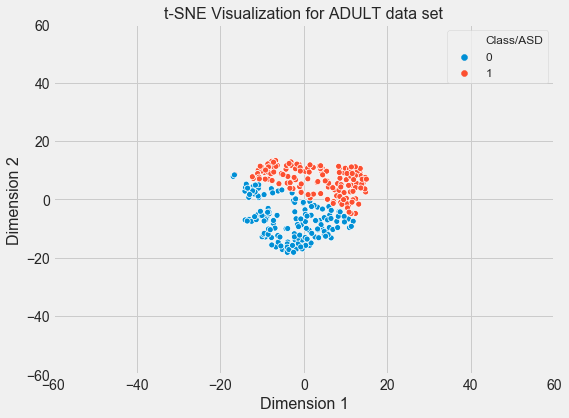

In [122]:
plot = nums[nums['age_desc'] ==0].values[:,0:-1]
plot.shape
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(plot)
# Plot
plt.figure(figsize=(8, 6))
ax = plt.subplot(111)
# cmap = sns.color_palette(n_colors=2)

sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1],
                     hue= 'Class/ASD',
#                      sizes=(100, 200),
                alpha = 1,
               data = nums[nums['age_desc'] ==0],
               )

plt.axis((-60, 60, -60, 60))
plt.title('t-SNE Visualization for ADULT data set', fontsize=16)
plt.xlabel('Dimension 1', fontsize=16)
plt.ylabel('Dimension 2', fontsize=16)
plt.legend(loc="best", fontsize=12)


### Correlation Map 

In [124]:
def plot_correlation(corr, title = ''):
    # plot the heatmap
    plt.figure(figsize=(10,8))
    sns.set_style(style = 'white')
    sns.heatmap(corr, 
                xticklabels=corr.columns,
                yticklabels=corr.columns,
               cmap=sns.diverging_palette(250, 10, as_cmap=True),
               square=True,
               mask=np.zeros_like(corr, dtype=np.bool))
    plt.title(title)
    return 

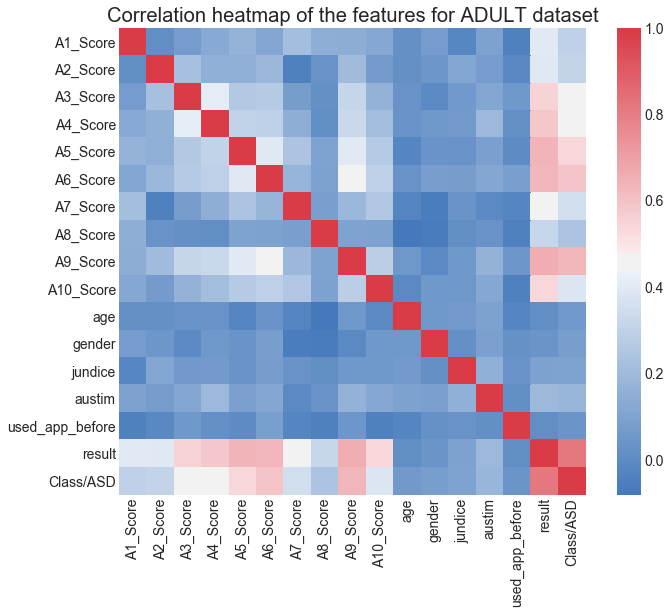

In [131]:
plot_correlation(adult_c.drop(columns = 'age_desc').corr(),
                 title = 'Correlation heatmap of the features for ADULT dataset')

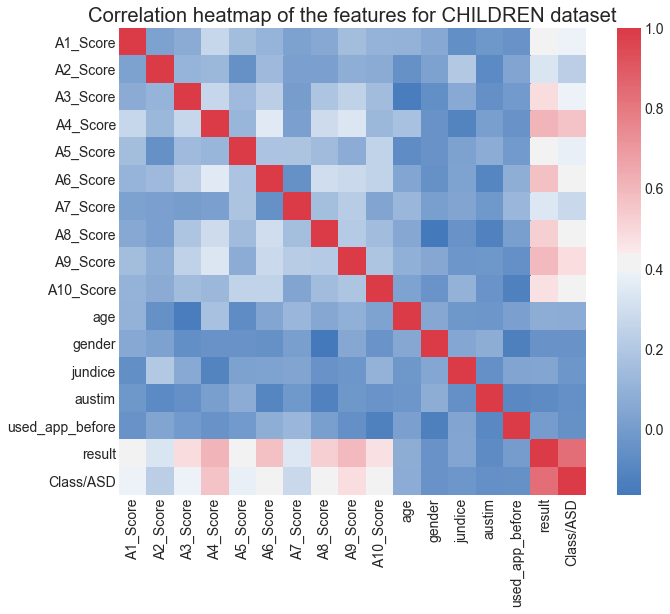

In [132]:
plot_correlation(children_c.drop(columns = 'age_desc').corr(),
                 title = 'Correlation heatmap of the features for CHILDREN dataset')

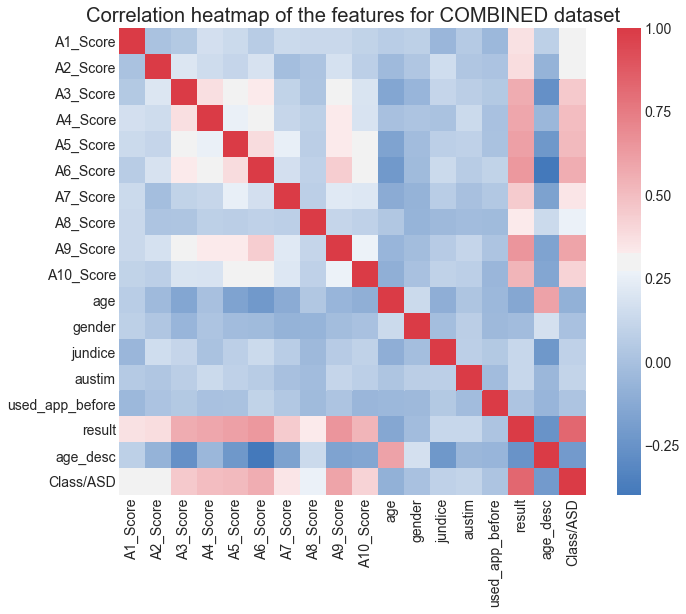

In [133]:
plot_correlation(combined.corr(),
                 title = 'Correlation heatmap of the features for COMBINED dataset')

In [25]:
# plt.figure(figsize=(10,10))
# sns.heatmap(corr, vmax=1, square=True,annot=True,cmap='cubehelix')

# Preprocessing 

In [141]:
# children_c = children_c.drop(columns=['result'])
# adult_c = adult_c.drop(columns=['result'])
# combined = combined.drop(columns=['result'])

In [142]:
def categ_to_num(df, cols):
    for col in cols:
        map_dict = {}
        for n, c in enumerate(np.flip(df[col].value_counts().index.values)):
            map_dict[c] = n + 1 
        df[col] = df[col].map(map_dict)
    return df

In [204]:
list(combined)

['A1_Score',
 'A2_Score',
 'A3_Score',
 'A4_Score',
 'A5_Score',
 'A6_Score',
 'A7_Score',
 'A8_Score',
 'A9_Score',
 'A10_Score',
 'age',
 'gender',
 'ethnicity',
 'jundice',
 'austim',
 'contry_of_res',
 'used_app_before',
 'result',
 'age_desc',
 'relation',
 'Class/ASD']

In [205]:
categorical = [
    'ethnicity',
    'contry_of_res',
    'relation'
]
clean = categ_to_num(combined, categorical)


In [206]:
clean.shape

(996, 21)

In [306]:
clean.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,...,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD,age_mv,ethnicity_mv,relation_mv
0,1,1,1,1,0,0,1,1,0,0,...,0,83,0,6.0,1,6.0,0,0,0,0
1,1,1,0,1,0,0,0,1,0,1,...,1,71,0,5.0,1,6.0,0,0,0,0
2,1,1,0,1,1,0,1,1,1,1,...,1,50,0,8.0,1,5.0,1,0,0,0
3,1,1,0,1,0,0,1,1,0,1,...,1,83,0,6.0,1,6.0,0,0,0,0
4,1,0,0,0,0,0,0,1,0,0,...,0,73,0,2.0,1,NaN,0,0,1,1


# train and test split

In [307]:
combined_model_df = clean
combined_model_df.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,...,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD,age_mv,ethnicity_mv,relation_mv
0,1,1,1,1,0,0,1,1,0,0,...,0,83,0,6.0,1,6.0,0,0,0,0
1,1,1,0,1,0,0,0,1,0,1,...,1,71,0,5.0,1,6.0,0,0,0,0
2,1,1,0,1,1,0,1,1,1,1,...,1,50,0,8.0,1,5.0,1,0,0,0
3,1,1,0,1,0,0,1,1,0,1,...,1,83,0,6.0,1,6.0,0,0,0,0
4,1,0,0,0,0,0,0,1,0,0,...,0,73,0,2.0,1,NaN,0,0,1,1


In [339]:
clean.age.isnull().any()

True

# train/test split 

In [387]:
for col in combined_model_df.columns:
    if pd.isna(combined_model_df[col]).any():# this needs to be the whole dataset.
        col_miss_ind = pd.isna(combined_model_df[col])
        combined_model_df[col+'_mv'] = col_miss_ind * 1
    pass

from sklearn.model_selection import train_test_split
cols = list(combined_model_df.columns)
cols.remove('Class/ASD')
X_train, X_test, y_train, y_test = train_test_split(
    combined_model_df[cols], combined_model_df['Class/ASD'],test_size = 0.33)

print(X_train.shape)
X_train.head()

(667, 23)


,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,...,jundice,austim,contry_of_res,used_app_before,result,age_desc,relation,age_mv,ethnicity_mv,relation_mv
268,1,0,1,1,1,0,0,1,0,0,...,0,0,83,0,5.0,1,6.0,0,0,0
270,1,0,1,1,1,1,0,0,1,1,...,0,1,68,0,7.0,1,NaN,0,1,1
310,1,0,1,0,0,0,0,0,0,0,...,0,0,83,0,2.0,1,6.0,0,0,0
736,1,0,0,1,0,1,1,1,1,1,...,0,0,73,0,7.0,0,NaN,1,1,1
662,1,0,0,1,1,1,0,0,1,0,...,0,0,64,0,5.0,1,6.0,0,0,0


### fill nan value with means

In [388]:
for col in X_train.columns:

    # indicate the missing row
    if pd.isna(clean[col]).any():# this needs to be the whole dataset.
        mean = X_train[col].mean()
        mean = int(mean)
        col_miss_ind = pd.isna(X_train[col])
    
        X_train.update(X_train[col].fillna(mean))
        X_test.update(X_test[col].fillna(mean))
    pass
X_train.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,...,jundice,austim,contry_of_res,used_app_before,result,age_desc,relation,age_mv,ethnicity_mv,relation_mv
268,1,0,1,1,1,0,0,1,0,0,...,0,0,83,0,5.0,1,6.0,0,0,0
270,1,0,1,1,1,1,0,0,1,1,...,0,1,68,0,7.0,1,5.0,0,1,1
310,1,0,1,0,0,0,0,0,0,0,...,0,0,83,0,2.0,1,6.0,0,0,0
736,1,0,0,1,0,1,1,1,1,1,...,0,0,73,0,7.0,0,5.0,1,1,1
662,1,0,0,1,1,1,0,0,1,0,...,0,0,64,0,5.0,1,6.0,0,0,0


In [389]:
# # normalization did not work. as there is nan valus in the dataset 
# from sklearn.preprocessing import Normalizer
# norm = Normalizer().fit(X_train) 
# X_train = norm.transform(X_train)
# X_test = norm.transform(X_test)

### standardize


In [390]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)  # Fit on training set only.
# Apply transform to both the training set and the test set.
# X_train = scaler.transform(X_train)
X_train = pd.DataFrame(scaler.transform(X_train) ,columns = X_train.columns, index = X_train.index)

# X_test = scaler.transform(X_test)
X_test = pd.DataFrame(scaler.transform(X_test) ,columns = X_test.columns, index = X_test.index)


C:\Users\64877\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\64877\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  """
C:\Users\64877\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  


In [391]:
X_train.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,...,jundice,austim,contry_of_res,used_app_before,result,age_desc,relation,age_mv,ethnicity_mv,relation_mv
268,0.647417,-0.931852,0.926250,0.98956,0.847981,-0.822119,-0.934663,0.801784,-0.771812,-1.279204,...,-0.384735,-0.402518,0.635597,-0.129492,-0.106317,0.633451,0.809379,-0.095274,-0.417487,-0.417487
270,0.647417,-0.931852,0.926250,0.98956,0.847981,1.216369,-0.934663,-1.247219,1.295652,0.781736,...,-0.384735,2.484360,-0.423908,-0.129492,0.690464,0.633451,-0.550459,-0.095274,2.395282,2.395282
310,0.647417,-0.931852,0.926250,-1.01055,-1.179271,-0.822119,-0.934663,-1.247219,-0.771812,-1.279204,...,-0.384735,-0.402518,0.635597,-0.129492,-1.301489,0.633451,0.809379,-0.095274,-0.417487,-0.417487
736,0.647417,-0.931852,-1.079622,0.98956,-1.179271,1.216369,1.069904,0.801784,1.295652,0.781736,...,-0.384735,-0.402518,-0.070740,-0.129492,0.690464,-1.578653,-0.550459,10.496031,2.395282,2.395282
662,0.647417,-0.931852,-1.079622,0.98956,0.847981,1.216369,-0.934663,-1.247219,1.295652,-1.279204,...,-0.384735,-0.402518,-0.706443,-0.129492,-0.106317,0.633451,0.809379,-0.095274,-0.417487,-0.417487


### PCA to reduce dimension

In [392]:
# from sklearn.decomposition import PCA
# # Make an instance of the Model
# # pca = PCA().fit(X_train)
# pca = PCA(n_components=2).fit(X_train)  # this is to reduce features to 2 dimension using PCA
# a = pca.transform(X_train)
# b = pca.transform(X_test)

In [393]:
# print (pd.DataFrame(pca.components_, columns=X_train.columns, index = ['PC-1','PC-2']))


In [362]:
# # this is that ratio plot. 2 features are not good using this one 
# sns.set_style('darkgrid')
# plt.figure(figsize=(12,8))
# plt.semilogy(pca.explained_variance_ratio_, '--o', label = 'explained variance ratio')
# plt.semilogy(pca.explained_variance_ratio_.cumsum(), '--o',label = 'cumulative explained variance ratio')
# plt.legend(loc = 'best')
# plt.title('PCA result')
# plt.xlabel('Principla Component')
# plt.ylabel('Explained Variance Ratio')

## Feature Selection using Lasso
- the result is X_transform, 2 dim

In [363]:
# from sklearn.linear_model import LassoCV
# from sklearn.feature_selection import SelectFromModel

# # We use the base estimator LassoCV since the L1 norm promotes sparsity of features.
# clf = LassoCV(cv=5)

# # Set a minimum threshold 
# sfm = SelectFromModel(clf, threshold=0.01).fit(X_train, y_train)

# n_features = sfm.transform(X_train).shape[1]
# # Reset the threshold till the number of features equals two.
# # Note that the attribute can be set directly instead of repeatedly
# # fitting the metatransformer.
# while n_features > 2:
#     sfm.threshold += 0.01
#     X_transform = sfm.transform(X_train)
#     n_features = X_transform.shape[1]
# X_test_transform = sfm.transform(X_test)

In [364]:
# [1 if i >0 else 0 for i in X_train.age_desc]

In [365]:
# trans_plot = pd.DataFrame(a)
# trans_plot['age_desc'] = [1 if i >0 else 0 for i in X_train.age_desc]
# trans_plot['label'] = y_train.values
# trans_plot.columns = ['Feature_1','Feature_2','age_desc','Class']
# plt.figure(figsize=(8,6))
# sns.scatterplot(x = "Feature_1", y="Feature_2",hue="Class", size ='age_desc',
#                         data = trans_plot)
# plt.title ('Scatter plot of data after PCA ')
# plt.show()

# Classifiers

In [394]:
%run ImportPlotFunctions.ipynb

##  train the model: logistic regression CV

Score:  1.0
F1 score:  1.0
1.0


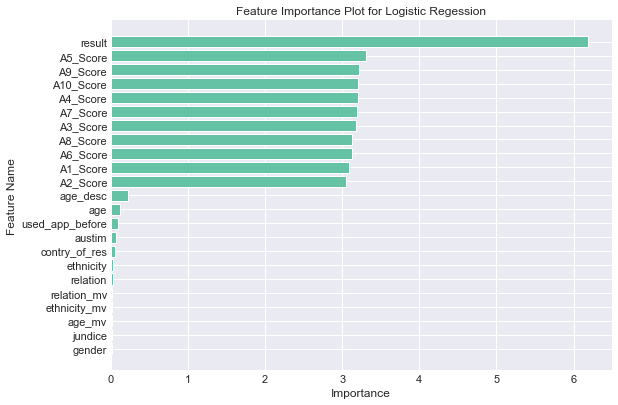

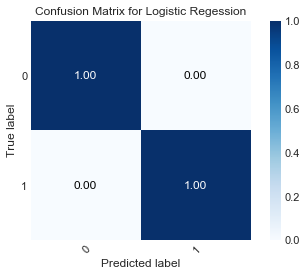

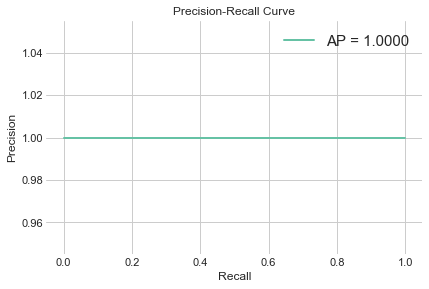

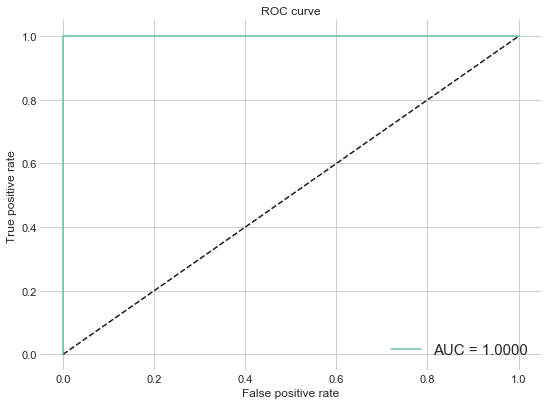

In [425]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression

clf = LogisticRegressionCV(cv = 5,random_state=42,
                           multi_class='auto').fit(X_train, y_train.values)
                           #solver = 'lbfgs')


print("Score: ", clf.score(X_test, y_test.values))
y_score = clf.predict_proba(X_test)[: , 1]
np.savetxt("./plot/y_score_lg.csv", y_score, delimiter=",")
print ('F1 score: ', f1_score(y_test.values,probability_to_label(y_score)))
print(metrics.accuracy_score(y_test.values, probability_to_label(y_score)))


# Feature Importance
names = cols
values = np.abs(clf.coef_[0])
feature_importance_bar(names, values, figsize=(8,6), title = 'Feature Importance Plot for Logistic Regession')
#plot
plot_cm(y_test, y_score, title = 'Confusion Matrix for Logistic Regession')
plot_PRC(y_test, y_score)
plot_ROC(y_test, y_score)

# Random forest

In [375]:
# from sklearn.ensemble import RandomForestClassifier
# clf = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)
# clf.score(X_test, y_test)

# print("Score: ", clf.score(X_test, y_test.values))
# y_score = clf.predict_proba(X_test)[: , 1]
# np.savetxt("./plot/y_score_rf.csv", y_score, delimiter=",")
# print ('F1 score: ', f1_score(y_test.values,probability_to_label(y_score)))


# # Feature Importance
# names = cols
# values = np.abs(clf.feature_importances_)
# feature_importance_bar(names, values, figsize=(8,6),title = 'Feature Importance Plot for Random Forest')
# #plot
# plot_cm(y_test, y_score, title = 'Confusino Matrix for Random Forest')
# plot_PRC(y_test, y_score)
# plot_ROC(y_test, y_score)

## SVM

Score:  1.0
F1 score:  1.0
1.0


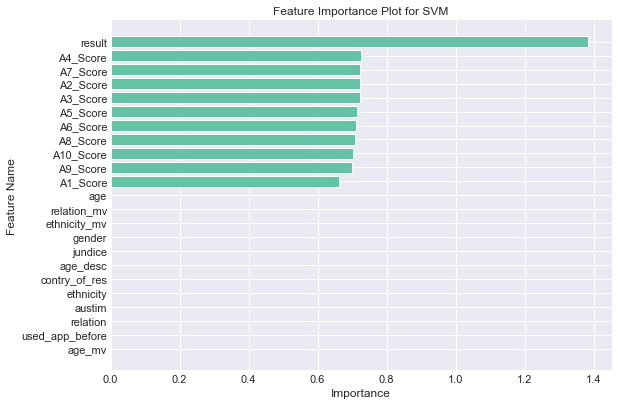

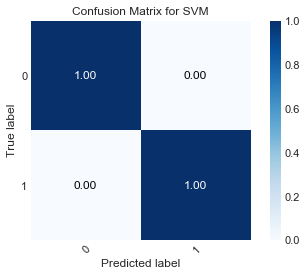

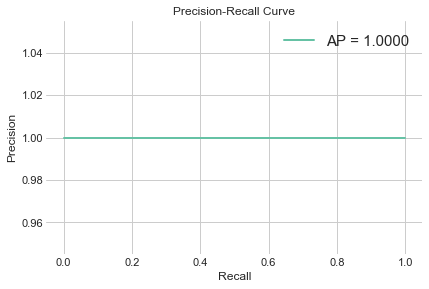

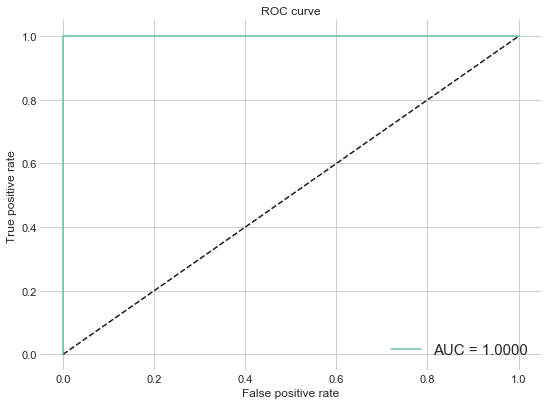

In [424]:
from sklearn.svm import SVC
clf = SVC(gamma='auto', probability = True, kernel = 'linear').fit(X_train, y_train)
clf.score(X_test,y_test.values)


print("Score: ", clf.score(X_test, y_test.values))
y_score = clf.predict_proba(X_test)[: , 1]
np.savetxt("./plot/y_score_svm.csv", y_score, delimiter=",")
print ('F1 score: ', f1_score(y_test.values,probability_to_label(y_score)))
print(metrics.accuracy_score(y_test.values, probability_to_label(y_score)))


# Feature Importance
names = cols
values = np.abs(clf.coef_[0])
feature_importance_bar(names, values, figsize=(8,6), title = 'Feature Importance Plot for SVM')
#plot
plot_cm(y_test, y_score,title = 'Confusion Matrix for SVM')
plot_PRC(y_test, y_score)
plot_ROC(y_test, y_score)

## kNN

Score:  0.9422492401215805
F1 score:  0.9177489177489178
0.9422492401215805


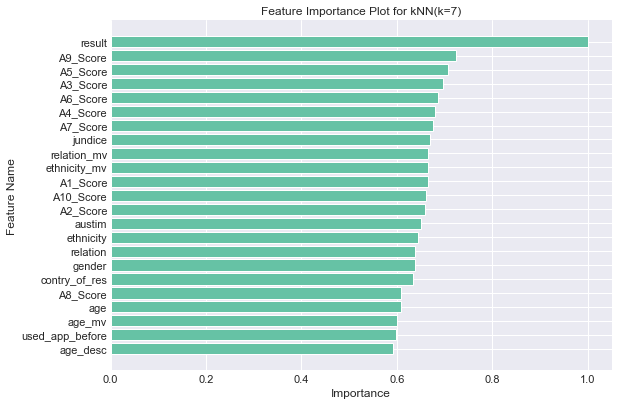

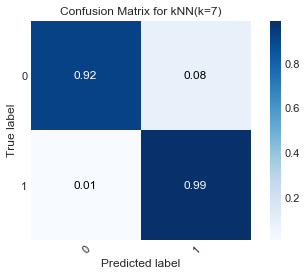

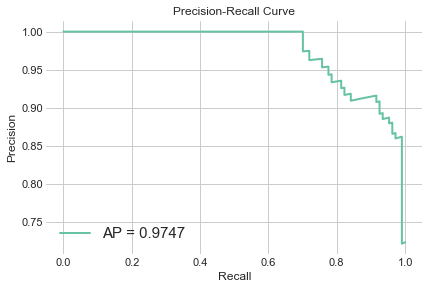

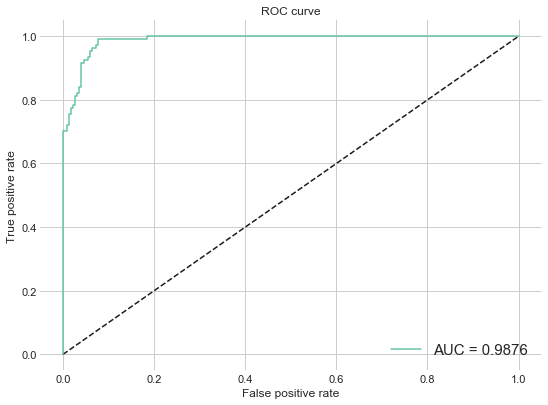

In [423]:
from sklearn import neighbors
from sklearn.model_selection import cross_val_score

clf = neighbors.KNeighborsClassifier(7, weights='distance').fit(X_train, y_train)
# clf.score(X_test,y_test)
print("Score: ", clf.score(X_test, y_test.values))
y_score = clf.predict_proba(X_test)[: , 1]
np.savetxt("./plot/y_score_knn.csv", y_score, delimiter=",")
print ('F1 score: ', f1_score(y_test.values,probability_to_label(y_score)))
print(metrics.accuracy_score(y_test.values, probability_to_label(y_score)))

n_feats = X_train.shape[1]
features = []
clf = neighbors.KNeighborsClassifier(7, weights='distance')#.fit(X_train, y_train)
for i in range(n_feats):
    X = X_train.values[:, i].reshape(-1, 1)
    scores = cross_val_score( clf, X, y_train, cv =5)
    features.append(scores.mean())
#     print('%d        %g' % (i, scores.mean()))

# Feature Importance
names = cols
values = features
feature_importance_bar(names, values, figsize=(8,6), title = "Feature Importance Plot for kNN(k=7)")
#plot
plot_cm(y_test, y_score, title= 'Confusion Matrix for kNN(k=7)')
plot_PRC(y_test, y_score)
plot_ROC(y_test, y_score)

## Linear regression

In [420]:
# y_score

Score:  0.6599747177501325
F1 score:  0.9203539823008848
0.9452887537993921


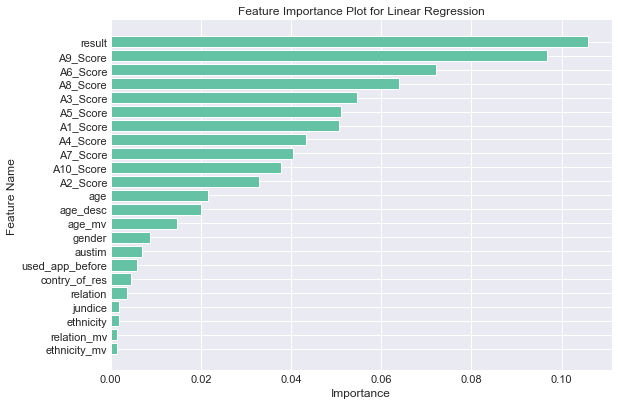

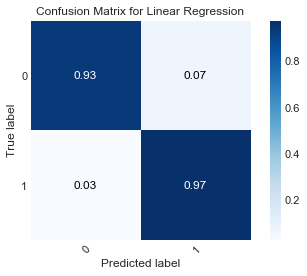

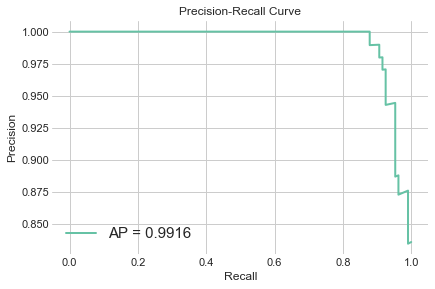

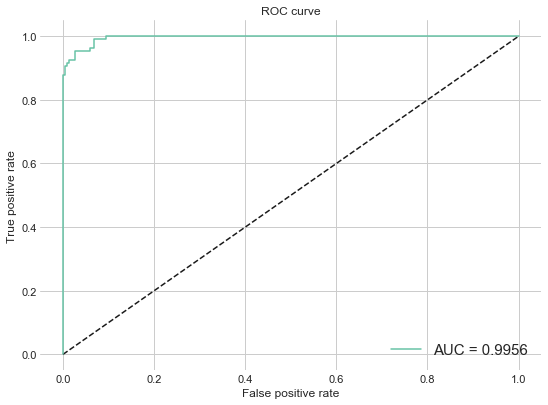

In [422]:
from sklearn.linear_model import LinearRegression
clf = LinearRegression().fit(X_train, y_train)
clf.score(X_test, y_test)

print("Score: ", clf.score(X_test, y_test))
y_score = clf.predict(X_test)
np.savetxt("./plot/y_score_linear.csv", y_score, delimiter=",")
print ('F1 score: ', f1_score(y_test.values, probability_to_label(y_score)))
print(metrics.accuracy_score(y_test.values, probability_to_label(y_score)))

# Feature Importance
names = cols
values = np.abs(clf.coef_)
feature_importance_bar(names, values, figsize=(8,6), title = 'Feature Importance Plot for Linear Regression')
#plot
plot_cm(y_test, y_score, title= 'Confusion Matrix for Linear Regression')
plot_PRC(y_test, y_score)
plot_ROC(y_test, y_score)

## Naive Bayes

In [401]:
# y_test

In [402]:
np.savetxt("./plot/y_test.csv", y_test, delimiter=",")


Score:  0.9422492401215805
F1 score:  0.9147982062780269
0.9422492401215805


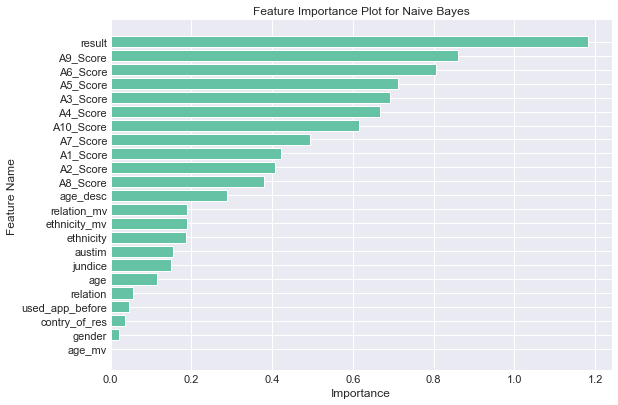

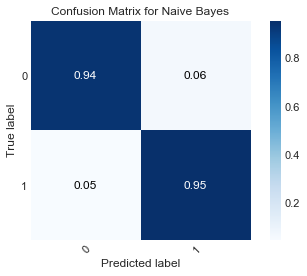

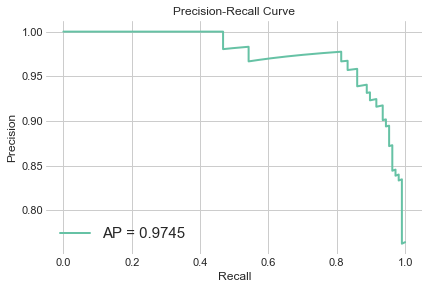

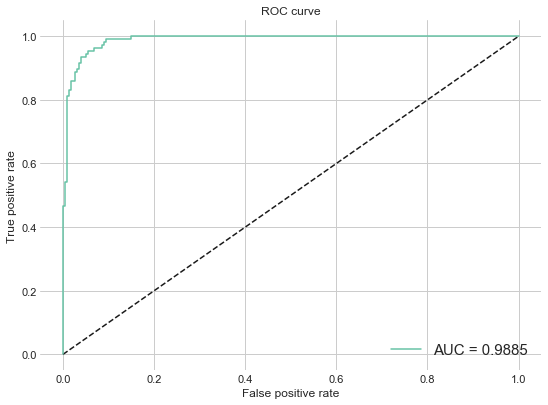

In [426]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB().fit(X_train, y_train.values)
clf.score(X_test, y_test.values)

print("Score: ", clf.score(X_test, y_test.values))
y_score = clf.predict_proba(X_test)[: , 1]
np.savetxt("./plot/y_score_gnb.csv", y_score, delimiter=",")
print ('F1 score: ', f1_score(y_test.values,probability_to_label(y_score)))
print(metrics.accuracy_score(y_test.values, probability_to_label(y_score)))

# Feature Importance
names = cols
values = np.abs(clf.theta_.T[:,1])
feature_importance_bar(names, values, figsize=(8,6), title = 'Feature Importance Plot for Naive Bayes')
#plot
plot_cm(y_test, y_score, title= 'Confusion Matrix for Naive Bayes')
plot_PRC(y_test, y_score)
plot_ROC(y_test, y_score)



# Performance metrics 

#### Confusion matrix

#### Probability Calibration curves
[Reference](https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html#sphx-glr-auto-examples-calibration-plot-calibration-curve-py)

In [353]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
from sklearn.svm import LinearSVC

# true label 
y = combined_model_df['Class/ASD'].values

def plot_calibration_curve(est, name, fig_index):
    """Plot calibration curve for est w/o and with calibration. """
    # Calibrated with isotonic calibration
    isotonic = CalibratedClassifierCV(est, cv=2, method='isotonic')

    # Calibrated with sigmoid calibration
    sigmoid = CalibratedClassifierCV(est, cv=2, method='sigmoid')

    # Logistic regression with no calibration as baseline
    lr = LogisticRegression(C=1., solver='lbfgs')

    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for clf, name in [(lr, 'Logistic'),
                      (est, name),
                      (isotonic, name + ' + Isotonic'),
                      (sigmoid, name + ' + Sigmoid')]:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(X_test)[:, 1]
        else:  # use decision function
            prob_pos = clf.decision_function(X_test)
            prob_pos = \
                (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

        clf_score = brier_score_loss(y_test, prob_pos, pos_label=y.max())
        print("%s:" % name)
        print("\tBrier: %1.3f" % (clf_score))
        print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
        print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
        print("\tF1: %1.3f\n" % f1_score(y_test, y_pred))

        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=10)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % (name, clf_score))

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()

In [231]:
# Plot calibration curve for Gaussian Naive Bayes
# plot_calibration_curve(GaussianNB(), "Naive Bayes", 1)

In [229]:
# Plot calibration curve for Linear SVC

# plot_calibration_curve(SVC(gamma='auto', probability = True), "SVM", 2)

Logistic:
	Brier: 0.003
	Precision: 1.000
	Recall: 1.000
	F1: 1.000

Logistic Regression:
	Brier: 0.001
	Precision: 1.000
	Recall: 1.000
	F1: 1.000

Logistic Regression + Isotonic:
	Brier: 0.001
	Precision: 1.000
	Recall: 1.000
	F1: 1.000

Logistic Regression + Sigmoid:
	Brier: 0.004
	Precision: 1.000
	Recall: 1.000
	F1: 1.000



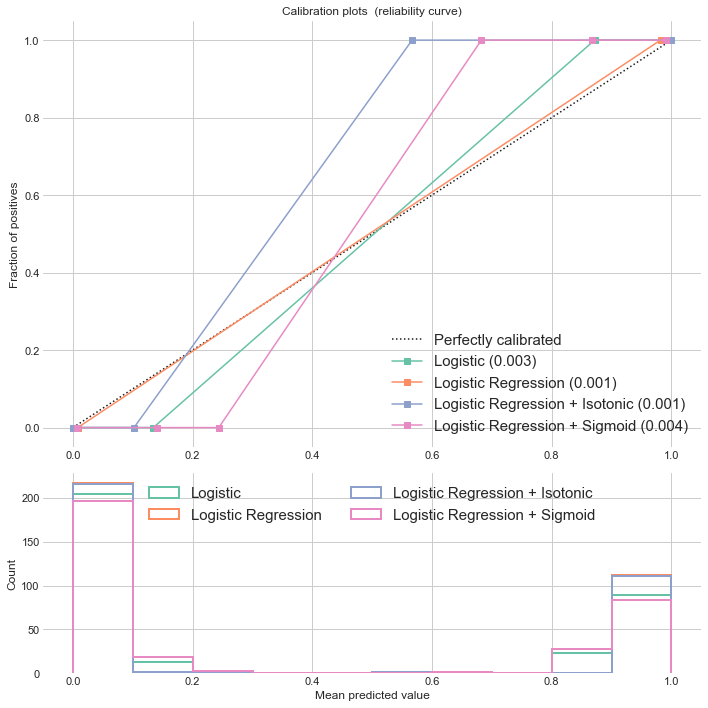

In [354]:

plot_calibration_curve(LogisticRegressionCV(cv = 10,random_state=0,multi_class='auto'), "Logistic Regression", 2)